In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [2]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, SeparableConv2D, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [3]:
class attrdict(dict):
    def __getattr__(self, name):
        return self[name]

    def __setattr__(self, name, value):
        self[name] = value

In [21]:
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')
model_dir = 'model'

width, height = 160, 160
resize = (width, height)
input_shape = (width, height, 1)
num_classes = 2

batch_size = 32
epochs = 20

In [5]:
data = attrdict()
classes = ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']
train_test_dir = ['train', 'test', 'val']

for class_ in classes: data[class_] = []

le = LabelEncoder()

print("[STATUS] Load images directory")
for dir_path in glob.glob(os.path.join(data_dir, '*')):
    kind_dir = os.path.split(dir_path)[-1]
    if kind_dir in train_test_dir:
        data[kind_dir] = attrdict()
        data[kind_dir]['x'], data[kind_dir]['y'] = [], []

        for path in glob.glob(os.path.join(dir_path, '*')):
            div = os.path.split(path)[-1]

            images = glob.glob(os.path.join(path, '*.jpeg'))
            if len(images) != 0:
                for image in tqdm(images, desc='Load ' + path):
                    image_name = os.path.split(image)[-1]
    
                    image = cv.imread(image, 0)
                    image = cv.resize(image, resize)
                    data[kind_dir]['x'].append(image)

                    if 'bacteria' in image_name:
                        target = classes[1]
                    elif 'virus' in image_name:
                        target = classes[2]
                    else:
                        target = div

                    if div != 'val':
                        data[target].append(image)

                    data[kind_dir]['y'].append(target)

        data[kind_dir]['x'] = np.array(data[kind_dir]['x'], dtype='f') / 255
        data[kind_dir]['x'] = data[kind_dir]['x'].reshape(data[kind_dir]['x'].shape[0], width, height, 1)
        data[kind_dir]['y'] = np.array(data[kind_dir]['y'])

        le.fit(data[kind_dir]['y'])
        data[kind_dir]['y'] = le.transform(data[kind_dir]['y'])
        data[kind_dir]['y'] = to_categorical(data[kind_dir]['y'], len(classes))

for class_ in classes: data[class_] = np.array(data[class_])

print("[STATUS] Load images completed")

[STATUS] Load images directory


Load data\val\PNEUMONIA: 100%|█████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.37it/s]


[STATUS] Load images completed


In [6]:
for kind in data:
    if kind in train_test_dir:
        print('%s\t: x%s\t| y%s' % 
              (kind, data[kind].x.shape, data[kind].y.shape))
    else:
        print('%s : %s' % (kind, data[kind].shape[0]))

NORMAL : 1583
PNEUMONIA_BACTERIA : 2780
PNEUMONIA_VIRUS : 1493
test	: x(624, 160, 160, 1)	| y(624, 3)
train	: x(5208, 160, 160, 1)	| y(5208, 3)
val	: x(24, 160, 160, 1)	| y(24, 3)


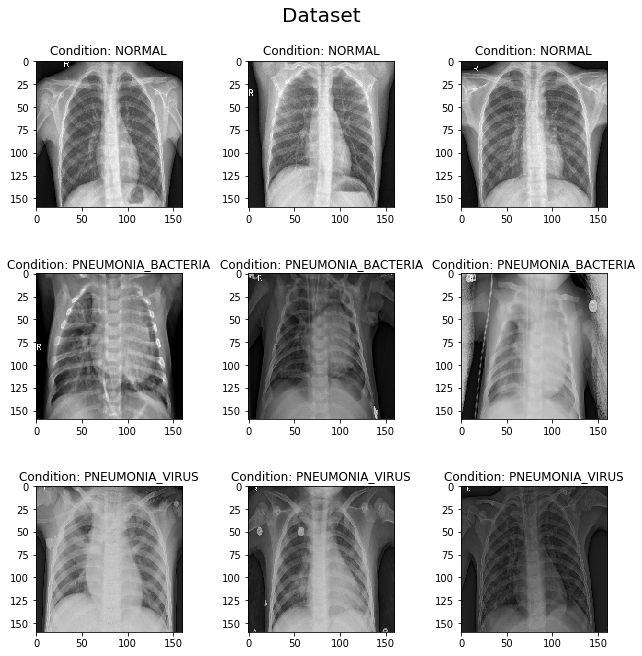

In [25]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))

for i in range(len(ax)):
    for j in range(len(ax[i])):
        image = data[classes[i]][j]
        ax[i][j].imshow(image.reshape(width, height), cmap='gray')
        ax[i][j].set_title('Condition: ' + classes[i])

fig.suptitle('Dataset', position=(.5, 1.025), fontsize=20)
fig.tight_layout()
fig.show()

In [8]:
data.train.x = np.concatenate((data.train.x, data.test.x), axis=0)
data.train.y = np.concatenate((data.train.y, data.test.y), axis=0)

print('train :', data.train.x.shape)

train : (5832, 160, 160, 1)


In [9]:
over_sampling = RandomOverSampler(random_state=42)
x = data.train.x.reshape(data.train.x.shape[0], width*height)
data.train.x, data.train.y = over_sampling.fit_resample(x, data.train.y)
data.train.x = data.train.x.reshape(data.train.x.shape[0], width, height, 1)

In [10]:
print('train :', data.train.x.shape)

train : (8316, 160, 160, 1)


In [11]:
data.train.x, data.test.x, data.train.y, data.test.y = \
train_test_split(data.train.x, data.train.y, test_size=0.10, random_state=42)

In [12]:
for kind in data:
    if kind in train_test_dir:
        print('%s\t: x%s\t| y%s' % 
              (kind, data[kind].x.shape, data[kind].y.shape))
#     else:
#         print('%s : %s' % (kind, data[kind].shape[0]))

test	: x(832, 160, 160, 1)	| y(832, 3)
train	: x(7484, 160, 160, 1)	| y(7484, 3)
val	: x(24, 160, 160, 1)	| y(24, 3)


In [22]:
K.clear_session()
model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    SeparableConv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    SeparableConv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    SeparableConv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    SeparableConv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    SeparableConv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.7),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(classes), activation='softmax')
])
model.compile(optimizer = Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath=os.path.join(model_dir, 'best_weights_three_class4.hdf5'), save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 80, 80, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 80, 80, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0

In [23]:
history = model.fit(data.train.x, data.train.y,
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    validation_data=(data.test.x, data.test.y), callbacks=[checkpoint, lr_reduce])

score = model.evaluate(data.test.x, data.test.y, verbose=0)
print('\nEvaluate')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7484 samples, validate on 832 samples
Epoch 1/20
7484/7484 [==============================] - 108s 14ms/sample - loss: 0.8462 - accuracy: 0.5565 - val_loss: 1.3157 - val_accuracy: 0.3293
Epoch 2/20
7484/7484 [==============================] - 105s 14ms/sample - loss: 0.6185 - accuracy: 0.7186 - val_loss: 1.9195 - val_accuracy: 0.3293
Epoch 3/20
7484/7484 [==============================] - 104s 14ms/sample - loss: 0.5498 - accuracy: 0.7569 - val_loss: 3.0314 - val_accuracy: 0.3317
Epoch 4/20
7484/7484 [==============================] - 105s 14ms/sample - loss: 0.5110 - accuracy: 0.7778 - val_loss: 0.6655 - val_accuracy: 0.7103
Epoch 5/20
7456/7484 [============================>.] - ETA: 0s - loss: 0.4880 - accuracy: 0.7922
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
7484/7484 [==============================] - 107s 14ms/sample - loss: 0.4889 - accuracy: 0.7918 - val_loss: 0.6651 - val_accuracy: 0.7200
Epoch 6/20
7484/7484 [===================

In [24]:
pred = model.predict_classes(data.test.x)
print("Performance report (test): \n %s \n" %(metrics.classification_report(np.argmax(data.test.y, axis=1), pred)))

Performance report (test): 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       273
           1       0.77      0.78      0.78       274
           2       0.76      0.75      0.76       285

    accuracy                           0.83       832
   macro avg       0.83      0.83      0.83       832
weighted avg       0.83      0.83      0.83       832
 



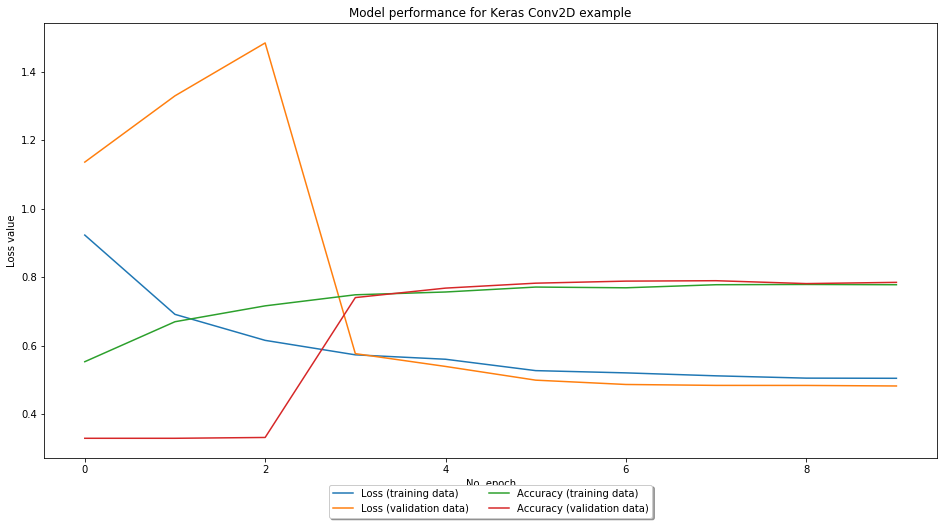

In [16]:
fig = plt.figure(figsize = (16, 8))
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for Keras Conv2D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()

In [17]:
# model.save(os.path.join(model_dir, 'pneumonia_classification_three_class_model4.hdf5'))

In [18]:
predictions = model.predict_classes(data.val.x).flatten()

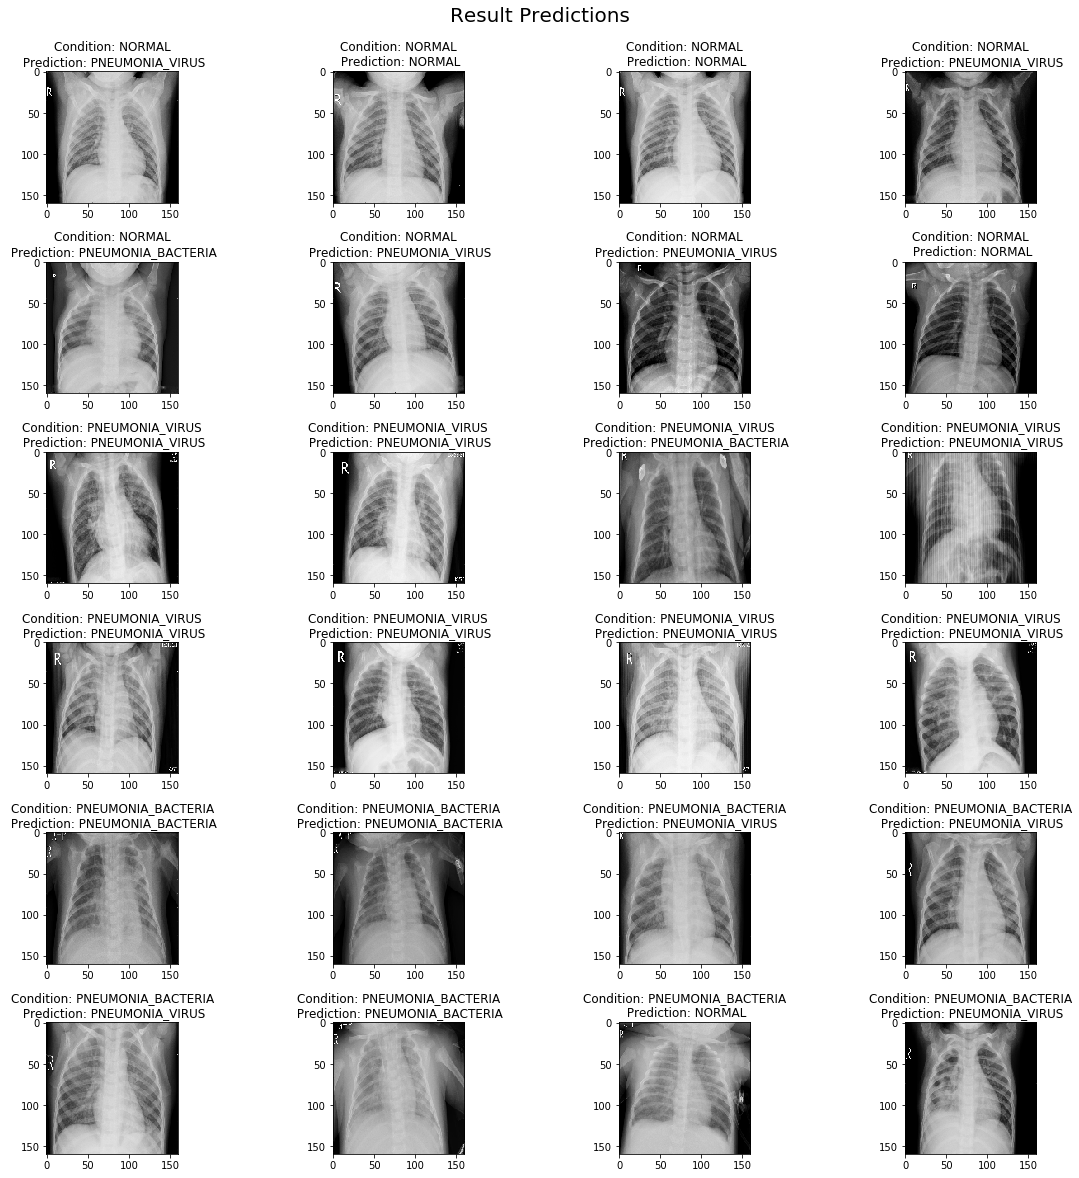

In [19]:
fig, ax = plt.subplots(6, 4, figsize=(16,16))
k = 0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].imshow(data.val.x[k].reshape(width, height), cmap='gray')
        ax[j][i].set_title('Condition: %s\n Prediction: %s' % (classes[np.argmax(data.val.y[k])], classes[predictions[k]]))
        k +=1

fig.suptitle('Result Predictions', position=(.5, 1.02), fontsize=20)
fig.tight_layout()
fig.show()